# Birmingham Purchase Cards Transactions <a class='tocSkip'>
-----
## Ana Isabel Rúa G.
## Msc.(c)Technology Information - Emphasis on Data Dcience <a class='tocSkip'>
#### https://github.com/anarua1203 

**Description:** With about 14  explanatory variables that describe (almost) all aspects of the corporate  purchase card transactions behavior for the Birmingham City Council, the idea for this paper is to use machine learning to explore and gain deeper knowledge from this data set.

** Where does this data comes from?:** Under the Code of Recommended Practice for Local Authorities on Data Transparency, councils are encouraged to publish all corporate purchase card transactions. 

Birmingham City Council has already publish details of all their relevant expenditure of more than £500 within Payments to Suppliers page, and will continue to do so. However, in the spirit of the Code, the Council started publishing all purchase card transactions, regardless of value, from the April 2014 card statement. 

Data: https://data.birmingham.gov.uk/dataset/purchase-card-transactions


**Problem tasks:** 
* (Clustering) Discovering profiles (whether the case) or unusual transactions (anomalies detection)
* (Forecasting) Try to guess future transactional behaviors. 

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from sklearn import preprocessing

# Load DataSet

In [2]:
data = pd.read_csv('../data/interim/purchase_card_trans_clean.csv', sep ='|')

In [3]:
data.head(2)

trans_date trans_vat_desc  original_gross_amt      merchant_name  \
0  2015-05-06             VR               38.28  shell corrida 108   
1  2015-05-14             VR               34.23      tex city sstn   

        card_number trans_cac_code_1 trans_cac_desc_1 trans_cac_code_2  \
0  ************0541             K020     Vehicle Fuel            RV12T   
1  ************0541             K020     Vehicle Fuel            RV12T   

                         trans_cac_desc_2 trans_cac_code_3  \
0  Shakti Elders Dce, 73 Conybere St, B12              A00   
1  Shakti Elders Dce, 73 Conybere St, B12              A00   

           directorate  
0  Adult & Communities  
1  Adult & Communities

In [4]:
df = data.copy()
#Casting trans_date variable to timestamp
df.trans_date = pd.to_datetime(df.trans_date)

#Creating new column with %Y-%m information
df['trans_date_ym'] = df.trans_date.dt.strftime('%Y-%m')
df['trans_date_year'] = df.trans_date.dt.strftime('%Y')

#Changing columns order

df = df[['trans_date', 'trans_date_ym','trans_date_year', 'trans_vat_desc', 'original_gross_amt', 'merchant_name',
       'card_number', 'trans_cac_code_1', 'trans_cac_desc_1',
       'trans_cac_code_2', 'trans_cac_desc_2', 'trans_cac_code_3',
       'directorate']]
df.head()

trans_date trans_date_ym trans_date_year trans_vat_desc  original_gross_amt  \
0 2015-05-06       2015-05            2015             VR               38.28   
1 2015-05-14       2015-05            2015             VR               34.23   
2 2015-05-21       2015-05            2015             VR               42.61   
3 2015-05-29       2015-05            2015             VR               43.57   
4 2015-05-07       2015-05            2015             VR               54.17   

       merchant_name       card_number trans_cac_code_1 trans_cac_desc_1  \
0  shell corrida 108  ************0541             K020     Vehicle Fuel   
1      tex city sstn  ************0541             K020     Vehicle Fuel   
2      tex city sstn  ************0541             K020     Vehicle Fuel   
3      tex city sstn  ************0541             K020     Vehicle Fuel   
4    shell kings 587  ************5770             K020     Vehicle Fuel   

  trans_cac_code_2                        trans_cac_desc_2 trans_cac_code_3  \
0            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
1            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
2            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
3            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
4            RV12N                    African-Caribbean DC              A00   

           directorate  
0  Adult & Communities  
1  Adult & Communities  
2  Adult & Communities  
3  Adult & Communities  
4  Adult & Communities

In [5]:
# Filter possitive gross amt - since there are few negative values, I will filter the dataset to work only with positive ones.
df = df[df['original_gross_amt']>0]

# I will impute the values of the column dictorate to deal with data governance problems
df['directorate'] = df['directorate'].str.lower().str.strip().str.replace('adults & comms','adults & communities').replace('adult & communities','adults & communities').replace('cyo&f','cyp&f schools').replace('cyp&f','cyp&f schools').replace('adults','adults & communities').replace('adult social care and health','adults & communities').replace(' ','_')

df['directorate'].value_counts()



cyp&f schools           102030
local services           32715
adults & communities     10144
corporate resources       9485
development               3003
Name: directorate, dtype: int64

In [6]:
# Groupby week
df_week = df[['trans_date','original_gross_amt','directorate']].groupby('directorate').resample('W-Mon',on='trans_date').sum().reset_index()
# Pivot table
df_week_pivot = pd.pivot_table(df_week,values='original_gross_amt',index='directorate',columns='trans_date',aggfunc=np.sum)#.fillna(0)
df_week_pivot

trans_date            2014-03-10  2014-03-17  2014-03-24  2014-03-31  \
directorate                                                            
adults & communities         NaN         NaN         NaN         NaN   
corporate resources          NaN         NaN         NaN         NaN   
cyp&f schools                NaN         NaN         NaN         NaN   
development                  NaN         NaN         NaN         NaN   
local services             98.33         0.0         0.0         0.0   

trans_date            2014-04-07  2014-04-14  2014-04-21  2014-04-28  \
directorate                                                            
adults & communities     4279.28     4543.15    10035.95     3698.84   
corporate resources     52886.89    63721.66    17062.47    58638.38   
cyp&f schools           25416.45    41186.26    13487.85    25201.96   
development              1147.28     3292.39     2618.68     1632.87   
local services           6956.61    14649.01     7081.28    11072.56   

trans_date            2014-05-05  2014-05-12  ...  2017-12-04  2017-12-11  \
directorate                                   ...                           
adults & communities     2533.05        0.00  ...     5427.23         0.0   
corporate resources     89487.72        0.00  ...     6565.57         0.0   
cyp&f schools           25168.45        0.00  ...    22733.04       238.8   
development              1300.02       80.98  ...      121.88         0.0   
local services           9925.73        0.00  ...   101129.15         0.0   

trans_date            2017-12-18  2017-12-25  2018-01-01  2018-01-08  \
directorate                                                            
adults & communities         0.0         0.0         0.0     1772.34   
corporate resources          0.0         0.0         0.0     7140.01   
cyp&f schools                0.0       179.9         0.0    14216.13   
development                  0.0         0.0         0.0      549.76   
local services               0.0         0.0         0.0   168741.91   

trans_date            2018-01-15  2018-01-22  2018-01-29  2018-02-05  
directorate                                                           
adults & communities     2608.99    15787.24     2529.72    42153.79  
corporate resources      7990.33    12525.81     9612.03   102621.99  
cyp&f schools           50143.48    52116.39    47955.35    56268.33  
development               699.84     1063.04      505.09      830.84  
local services         233117.10   219846.95   325658.58   255733.85  

[5 rows x 205 columns]

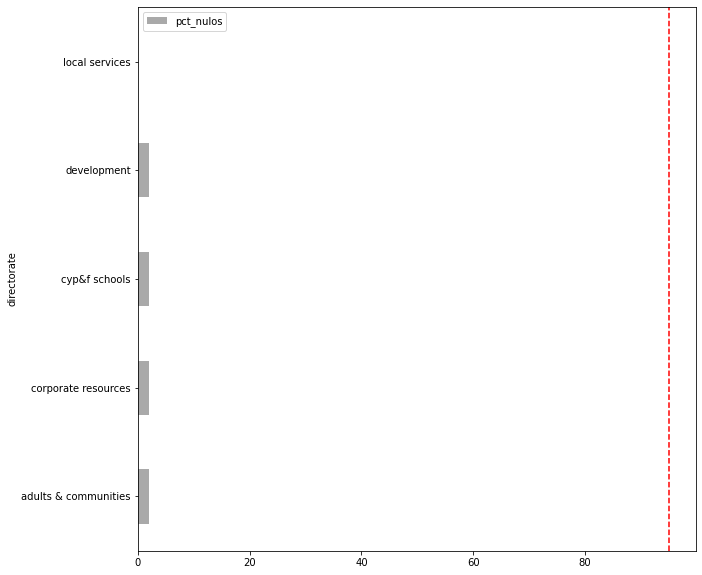

In [7]:
umbral_nan_r = 95
df_columnas = df_week_pivot.shape[1]
df_nan_r = pd.DataFrame(df_week_pivot.isnull().sum(axis=1))#.reset_index(level=0)
df_nan_r.rename(columns={"index": "indice", 0: "num_nulos"}, inplace=True)
df_nan_r['pct_nulos'] = (df_nan_r['num_nulos']/df_columnas)*100

df_nan_r.sort_values(by=['pct_nulos'], ascending=False).iloc[0:31,:].plot.barh( y='pct_nulos', color='darkgray',figsize=(10, 10))
plt.axvline(umbral_nan_r, color='red', linestyle='--');

Because the database presents NaN, we change the data values by 0 to identify the areas of the time series where we have missing data. It should be noted that a purchase never has 0 value.

In [8]:
## Normalize

x = df_week_pivot.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled, index=df_week_pivot.index,columns=df_week_pivot.columns)

# Fill na's with 0
df_norm.fillna(0,inplace=True)
df_norm

trans_date            2014-03-10  2014-03-17  2014-03-24  2014-03-31  \
directorate                                                            
adults & communities         0.0         0.0         0.0         0.0   
corporate resources          0.0         0.0         0.0         0.0   
cyp&f schools                0.0         0.0         0.0         0.0   
development                  0.0         0.0         0.0         0.0   
local services               0.0         0.0         0.0         0.0   

trans_date            2014-04-07  2014-04-14  2014-04-21  2014-04-28  \
directorate                                                            
adults & communities    0.060534    0.020698    0.513527    0.036242   
corporate resources     1.000000    1.000000    1.000000    1.000000   
cyp&f schools           0.469064    0.627078    0.752515    0.413453   
development             0.000000    0.000000    0.000000    0.000000   
local services          0.112280    0.187932    0.308963    0.165593   

trans_date            2014-05-05  2014-05-12  ...  2017-12-04  2017-12-11  \
directorate                                   ...                           
adults & communities    0.013982         0.0  ...    0.052524         0.0   
corporate resources     1.000000         0.0  ...    0.063794         0.0   
cyp&f schools           0.270655         0.0  ...    0.223857         1.0   
development             0.000000         1.0  ...    0.000000         0.0   
local services          0.097811         0.0  ...    1.000000         0.0   

trans_date            2017-12-18  2017-12-25  2018-01-01  2018-01-08  \
directorate                                                            
adults & communities         0.0         0.0         0.0    0.007269   
corporate resources          0.0         0.0         0.0    0.039183   
cyp&f schools                0.0         1.0         0.0    0.081255   
development                  0.0         0.0         0.0    0.000000   
local services               0.0         0.0         0.0    1.000000   

trans_date            2018-01-15  2018-01-22  2018-01-29  2018-02-05  
directorate                                                           
adults & communities    0.008214    0.067300    0.006227    0.162112  
corporate resources     0.031368    0.052393    0.028008    0.399333  
cyp&f schools           0.212737    0.233351    0.145932    0.217485  
development             0.000000    0.000000    0.000000    0.000000  
local services          1.000000    1.000000    1.000000    1.000000  

[5 rows x 205 columns]

<AxesSubplot:xlabel='trans_date'>

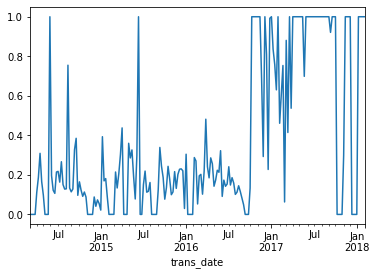

In [9]:
df_norm.loc['local services'].plot()

<AxesSubplot:xlabel='trans_date'>

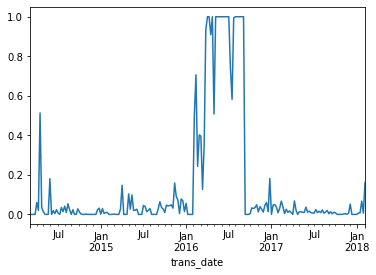

In [10]:
df_norm.loc['adults & communities'].plot()

<AxesSubplot:xlabel='trans_date'>

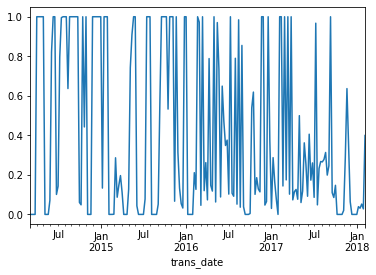

In [11]:
df_norm.loc['corporate resources'].plot()

<AxesSubplot:xlabel='trans_date'>

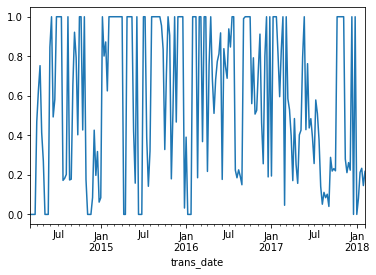

In [12]:
df_norm.loc['cyp&f schools'].plot()

<AxesSubplot:xlabel='trans_date'>

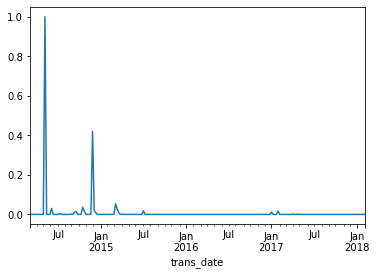

In [13]:
df_norm.loc['development'].plot()


In [14]:
# I reset index iin order to keep it as a column for the saving process
df_norm.reset_index(inplace=True)
df_norm

trans_date           directorate  2014-03-10 00:00:00  2014-03-17 00:00:00  \
0           adults & communities                  0.0                  0.0   
1            corporate resources                  0.0                  0.0   
2                  cyp&f schools                  0.0                  0.0   
3                    development                  0.0                  0.0   
4                 local services                  0.0                  0.0   

trans_date  2014-03-24 00:00:00  2014-03-31 00:00:00  2014-04-07 00:00:00  \
0                           0.0                  0.0             0.060534   
1                           0.0                  0.0             1.000000   
2                           0.0                  0.0             0.469064   
3                           0.0                  0.0             0.000000   
4                           0.0                  0.0             0.112280   

trans_date  2014-04-14 00:00:00  2014-04-21 00:00:00  2014-04-28 00:00:00  \
0                      0.020698             0.513527             0.036242   
1                      1.000000             1.000000             1.000000   
2                      0.627078             0.752515             0.413453   
3                      0.000000             0.000000             0.000000   
4                      0.187932             0.308963             0.165593   

trans_date  2014-05-05 00:00:00  ...  2017-12-04 00:00:00  \
0                      0.013982  ...             0.052524   
1                      1.000000  ...             0.063794   
2                      0.270655  ...             0.223857   
3                      0.000000  ...             0.000000   
4                      0.097811  ...             1.000000   

trans_date  2017-12-11 00:00:00  2017-12-18 00:00:00  2017-12-25 00:00:00  \
0                           0.0                  0.0                  0.0   
1                           0.0                  0.0                  0.0   
2                           1.0                  0.0                  1.0   
3                           0.0                  0.0                  0.0   
4                           0.0                  0.0                  0.0   

trans_date  2018-01-01 00:00:00  2018-01-08 00:00:00  2018-01-15 00:00:00  \
0                           0.0             0.007269             0.008214   
1                           0.0             0.039183             0.031368   
2                           0.0             0.081255             0.212737   
3                           0.0             0.000000             0.000000   
4                           0.0             1.000000             1.000000   

trans_date  2018-01-22 00:00:00  2018-01-29 00:00:00  2018-02-05 00:00:00  
0                      0.067300             0.006227             0.162112  
1                      0.052393             0.028008             0.399333  
2                      0.233351             0.145932             0.217485  
3                      0.000000             0.000000             0.000000  
4                      1.000000             1.000000             1.000000  

[5 rows x 206 columns]

In [15]:
## Save df
df_norm.to_csv('../data/interim/serie_directorate.csv',sep='|', index=False)

# Understanding original_gross_amount

Text(0, 0.5, 'ORIGINAL GROSS AMT')

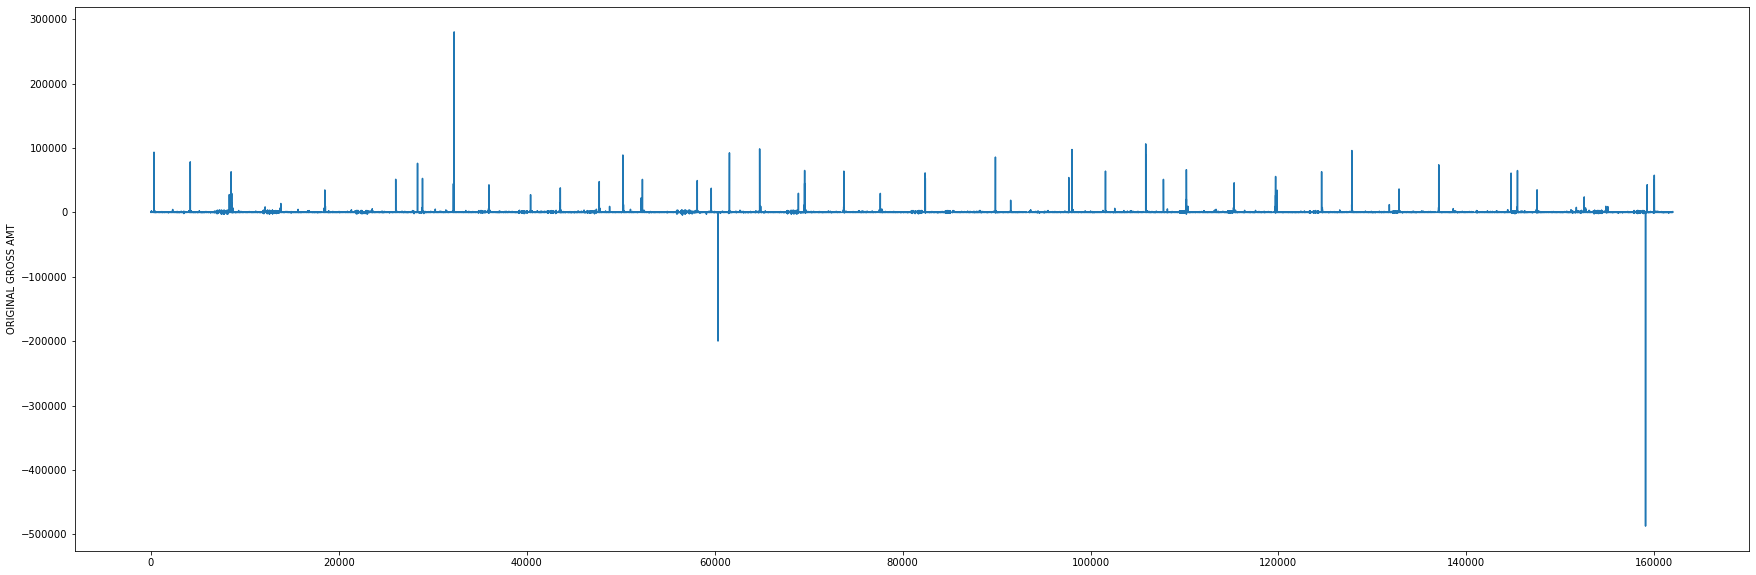

In [35]:
plt.figure(figsize=(30,10))
plt.plot(data['original_gross_amt'])
#plt.xlabel('Dates')
plt.ylabel('ORIGINAL GROSS AMT')

/Users/danielaacosta/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='original_gross_amt', ylabel='Density'>

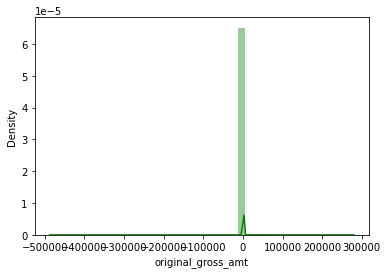

In [36]:
sns.distplot(df.original_gross_amt, color='g')


## Card Number

In [37]:
## Unique credit cards
len(data['card_number'].unique())

1500

In [38]:
# Frequency of transactions made by each unique card
card_vc = df['card_number'].value_counts()

# Transforming it into a DataFrame
card_vc = pd.DataFrame(card_vc)
card_vc = card_vc.reset_index()
card_vc.columns = ['unique_card','counts']

In [9]:
card_vc.head()

unique_card  counts
0  ************6308    2441
1  ************6720    2154
2  ************6316    2029
3  ************7710    1775
4  ************6387    1168

In [15]:
# How many months history have each credit card

df.sort_values('card_number',inplace=True)



In [18]:
# Get the total amount of months where card was used
df['months_use'] = df.groupby('card_number')['trans_date_ym'].transform('nunique')

In [34]:
df.head()

trans_date trans_date_ym trans_vat_desc  original_gross_amt  \
160420 2014-08-27       2014-08             VR               45.00   
93988  2014-06-07       2014-06             VR               21.50   
93987  2014-06-25       2014-06             VZ                1.72   
141444 2014-09-25       2014-09             VZ               91.65   
141443 2014-09-25       2014-09             VZ                5.98   

              merchant_name       card_number trans_cac_code_1  \
160420   g f europe limited  ************0007             L300   
93988       hobby craft ltd  ************0007             L100   
93987   post office counter  ************0007             L700   
141444             wh smith  ************0007             L000   
141443             wh smith  ************0007             L000   

            trans_cac_desc_1 trans_cac_code_2 trans_cac_desc_2  \
160420     Clothing&Uniforms            RECPP            PATHS   
93988      Equip Operational            RECPP            PATHS   
93987                Postage            RECPP            PATHS   
141444  N'Papers&Periodicals            RECPP            PATHS   
141443  N'Papers&Periodicals            RECPP            PATHS   

       trans_cac_code_3 directorate  months_use  
160420              A00       CYP&F           3  
93988               A00       CYP&F           3  
93987               A00       CYP&F           3  
141444              A00       CYP&F           3  
141443              A00       CYP&F           3

In [19]:
df_unique =  df[['card_number','months_use']].drop_duplicates()
#sns.catplot(x='card_number',y='months_use',data = df_unique)

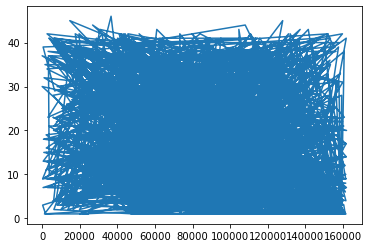

In [20]:
plt.plot(df_unique['months_use'])

In [21]:
df.head(2)

trans_date trans_date_ym trans_vat_desc  original_gross_amt  \
160420 2014-08-27       2014-08             VR                45.0   
93988  2014-06-07       2014-06             VR                21.5   

             merchant_name       card_number trans_cac_code_1  \
160420  g f europe limited  ************0007             L300   
93988      hobby craft ltd  ************0007             L100   

         trans_cac_desc_1 trans_cac_code_2 trans_cac_desc_2 trans_cac_code_3  \
160420  Clothing&Uniforms            RECPP            PATHS              A00   
93988   Equip Operational            RECPP            PATHS              A00   

       directorate  months_use  
160420       CYP&F           3  
93988        CYP&F           3

In [41]:
df_pivot =  pd.pivot_table(df,values='original_gross_amt',index='card_number',columns='trans_date_ym',aggfunc=np.sum)

In [42]:
df_pivot.head()

trans_date_ym     2013-11  2014-03  2014-04  2014-05  2014-06  2014-07  \
card_number                                                              
************0007      NaN      NaN      NaN      NaN    23.22      NaN   
************0015      NaN      NaN      NaN      NaN      NaN      NaN   
************0024      NaN      NaN      NaN      NaN      NaN      NaN   
************0025      NaN      NaN      NaN      NaN      NaN      NaN   
************0040      NaN      NaN    92.42      NaN    95.30    93.81   

trans_date_ym     2014-08  2014-09  2014-10  2014-11  ...  2017-05  2017-06  \
card_number                                           ...                     
************0007    69.97    97.63      NaN      NaN  ...      NaN      NaN   
************0015      NaN    48.04      NaN      NaN  ...      NaN      NaN   
************0024      NaN      NaN      NaN      NaN  ...      NaN      NaN   
************0025      NaN      NaN      NaN      NaN  ...   195.54   368.85   
************0040      NaN   100.10      NaN      NaN  ...   168.46      NaN   

trans_date_ym     2017-07  2017-08  2017-09  2017-10  2017-11  2017-12  \
card_number                                                              
************0007      NaN      NaN      NaN      NaN      NaN      NaN   
************0015      NaN      NaN      NaN      NaN      NaN      NaN   
************0024      NaN      NaN      NaN      NaN      NaN      NaN   
************0025  1223.00     48.6  1854.84  1393.88  1371.21      NaN   
************0040    81.83      NaN    84.64      NaN      NaN      NaN   

trans_date_ym     2018-01  2018-02  
card_number                         
************0007      NaN      NaN  
************0015      NaN      NaN  
************0024      NaN      NaN  
************0025    780.5   813.12  
************0040      NaN      NaN  

[5 rows x 49 columns]

In [44]:
df_pivot.fillna(0,inplace=True)

In [43]:
#df_pivot.reset_index('card_number',inplace=True)

In [ ]:
df

<AxesSubplot:xlabel='trans_date_ym'>

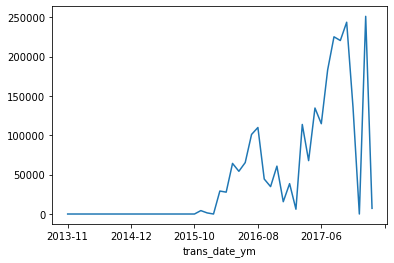

In [51]:
df_pivot.loc['************6308'][0:].plot()

<AxesSubplot:xlabel='trans_date_ym'>

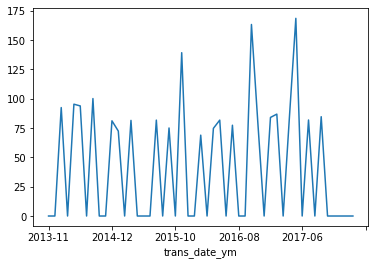

In [53]:
df_pivot.loc['************0040'].plot()

<AxesSubplot:xlabel='trans_date_ym'>

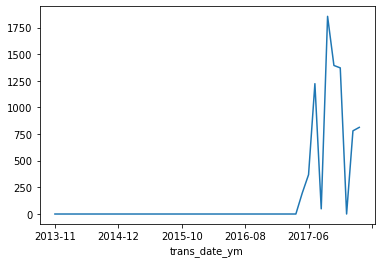

In [54]:
df_pivot.loc['************0025'].plot()

# Directorate

In [5]:
df2 = df.copy()

In [62]:
df['directorate'].str.lower().str.strip()

0         adult & communities
1         adult & communities
2         adult & communities
3         adult & communities
4         adult & communities
                 ...         
161957         local services
161958         local services
161959         local services
161960         local services
161961         local services
Name: directorate, Length: 157377, dtype: object

In [65]:
# Only possitive gross amt
df = df[df['original_gross_amt']>0]
df['directorate'] = df['directorate'].str.lower().str.strip()
#df['directorate'].value_counts()


In [64]:
# Only possitive gross amt
df = df[df['original_gross_amt']>0]
df['directorate'] = df['directorate'].str.lower().str.strip()
#df['directorate'].value_counts()

# Frequency of transactions made by each unique card
directorate_df = df['directorate'].value_counts()

# Transforming it into a DataFrame
directorate_df = pd.DataFrame(directorate_df)
directorate_df = directorate_df.reset_index()
directorate_df.columns = ['directorate','counts']
directorate_df

directorate  counts
0                  cyp&f schools   82484
1                 local services   32715
2                          cyp&f   19472
3            adult & communities    9731
4            corporate resources    9485
5                    development    3003
6   adult social care and health     344
7                          cyo&f      74
8                 adults & comms      35
9                         adults      21
10          adults & communities      13

In [66]:
# Get the total amount of months where card was used
df['months_use'] = df.groupby('directorate')['trans_date_ym'].transform('nunique')
df.head()

trans_date trans_date_ym trans_date_year trans_vat_desc  original_gross_amt  \
0 2015-05-06       2015-05            2015             VR               38.28   
1 2015-05-14       2015-05            2015             VR               34.23   
2 2015-05-21       2015-05            2015             VR               42.61   
3 2015-05-29       2015-05            2015             VR               43.57   
4 2015-05-07       2015-05            2015             VR               54.17   

       merchant_name       card_number trans_cac_code_1 trans_cac_desc_1  \
0  shell corrida 108  ************0541             K020     Vehicle Fuel   
1      tex city sstn  ************0541             K020     Vehicle Fuel   
2      tex city sstn  ************0541             K020     Vehicle Fuel   
3      tex city sstn  ************0541             K020     Vehicle Fuel   
4    shell kings 587  ************5770             K020     Vehicle Fuel   

  trans_cac_code_2                        trans_cac_desc_2 trans_cac_code_3  \
0            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
1            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
2            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
3            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
4            RV12N                    African-Caribbean DC              A00   

           directorate  months_use          directorare  
0  adult & communities          42  adult & communities  
1  adult & communities          42  adult & communities  
2  adult & communities          42  adult & communities  
3  adult & communities          42  adult & communities  
4  adult & communities          42  adult & communities

In [67]:
print (f'max num meses: {df.months_use.max()}, min num meses: {df.months_use.min()}')

max num meses: 47, min num meses: 3


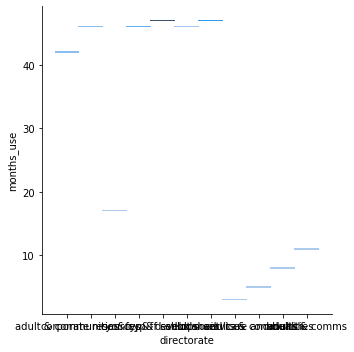

In [68]:
sns.displot(x=df.directorate,y=df['months_use'])

In [69]:
df.head()

trans_date trans_date_ym trans_date_year trans_vat_desc  original_gross_amt  \
0 2015-05-06       2015-05            2015             VR               38.28   
1 2015-05-14       2015-05            2015             VR               34.23   
2 2015-05-21       2015-05            2015             VR               42.61   
3 2015-05-29       2015-05            2015             VR               43.57   
4 2015-05-07       2015-05            2015             VR               54.17   

       merchant_name       card_number trans_cac_code_1 trans_cac_desc_1  \
0  shell corrida 108  ************0541             K020     Vehicle Fuel   
1      tex city sstn  ************0541             K020     Vehicle Fuel   
2      tex city sstn  ************0541             K020     Vehicle Fuel   
3      tex city sstn  ************0541             K020     Vehicle Fuel   
4    shell kings 587  ************5770             K020     Vehicle Fuel   

  trans_cac_code_2                        trans_cac_desc_2 trans_cac_code_3  \
0            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
1            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
2            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
3            RV12T  Shakti Elders Dce, 73 Conybere St, B12              A00   
4            RV12N                    African-Caribbean DC              A00   

           directorate  months_use          directorare  
0  adult & communities          42  adult & communities  
1  adult & communities          42  adult & communities  
2  adult & communities          42  adult & communities  
3  adult & communities          42  adult & communities  
4  adult & communities          42  adult & communities

In [70]:
df_pivot =  pd.pivot_table(df,values='original_gross_amt',index='directorate',columns='trans_date_ym',aggfunc=np.sum)#.fillna(0)

In [71]:
df_pivot

trans_date_ym                 2014-03    2014-04   2014-05    2014-06  \
directorate                                                             
adult & communities               NaN   22857.36    500.25   14621.83   
adult social care and health      NaN        NaN       NaN        NaN   
adults                            NaN        NaN       NaN        NaN   
adults & comms                    NaN    1732.66       NaN        NaN   
adults & communities              NaN        NaN       NaN     652.78   
corporate resources               NaN  239080.37  42716.75  257292.64   
cyo&f                             NaN        NaN       NaN        NaN   
cyp&f                             NaN   27001.34   1152.93   31416.82   
cyp&f schools                     NaN   98045.29   4261.41  185625.70   
development                       NaN    9845.25    226.97   13100.16   
local services                  98.33   47208.29   2476.90   55650.17   

trans_date_ym                   2014-07    2014-08    2014-09    2014-10  \
directorate                                                                
adult & communities            15442.64   14275.49   17066.31   19727.23   
adult social care and health        NaN        NaN        NaN        NaN   
adults                              NaN        NaN        NaN        NaN   
adults & comms                  1367.09    1403.89    1211.60        NaN   
adults & communities             227.78        NaN        NaN        NaN   
corporate resources           266494.16  272833.70  296056.09  189145.81   
cyo&f                               NaN        NaN        NaN        NaN   
cyp&f                          54233.55   38349.91   26988.07   36895.37   
cyp&f schools                 183333.56   25855.74  165109.72  169267.98   
development                    11529.43   12357.19   14656.85   22551.28   
local services                 78773.31   48136.35   71255.67   48909.25   

trans_date_ym                 2014-11    2014-12  ...    2017-05    2017-06  \
directorate                                       ...                         
adult & communities               NaN   12044.56  ...   12005.34   10268.57   
adult social care and health      NaN        NaN  ...        NaN        NaN   
adults                            NaN        NaN  ...        NaN        NaN   
adults & comms                    NaN    2918.49  ...        NaN        NaN   
adults & communities              NaN        NaN  ...        NaN        NaN   
corporate resources            408.00  601199.48  ...  102305.23  125412.27   
cyo&f                             NaN        NaN  ...        NaN        NaN   
cyp&f                          419.43   35391.82  ...   29197.63   30433.85   
cyp&f schools                 1182.59  122702.57  ...  358671.37  182906.77   
development                    251.06   14707.66  ...    4017.17    4247.58   
local services                  85.55   45291.33  ...  485049.22  569404.43   

trans_date_ym                   2017-07    2017-08    2017-09     2017-10  \
directorate                                                                 
adult & communities            11840.93   12535.48    9920.93      343.49   
adult social care and health        NaN        NaN        NaN         NaN   
adults                              NaN        NaN        NaN         NaN   
adults & comms                      NaN        NaN        NaN         NaN   
adults & communities                NaN        NaN        NaN         NaN   
corporate resources           214537.64  184398.54  290825.55      281.38   
cyo&f                               NaN        NaN        NaN         NaN   
cyp&f                          37000.60   30517.27   26345.42     1949.76   
cyp&f schools                 206584.40   24957.03  161484.12  1348688.60   
development                     3305.09    2777.99    2941.02      181.60   
local services                659414.07  718294.37  823773.81    39889.04   

trans_date_ym                  

In [72]:
# Funcion para calcular el % de datos faltantes para cada columnas 
def missing_values_table(df_adf_append):
    # Total valores faltantes
    mis_val = df_adf_append.isnull().sum()
    
    # % valores faltantes 
    mis_val_percent = 100 * df_adf_append.isnull().sum() / len(df_adf_append)
    
    # Tabla para presentar datos
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renombrar columnas
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing ', 1 : '% of Total Values'})
    
    # Ordena la tabla de mayor faltantes a menor
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print resumen
    print ("Dataframe has " + str(df_adf_append.shape[1]) + " columnas.\n"      
        "of which " + str(mis_val_table_ren_columns.shape[0]) +
            " have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [73]:
missing_values_table(df_pivot)

Dataframe has 48 columnas.
of which 48 have missing values.


Missing   % of Total Values
trans_date_ym                             
2014-03              10               90.9
2017-12              10               90.9
2014-11               6               54.5
2018-01               5               45.5
2017-11               5               45.5
2017-10               5               45.5
2017-09               5               45.5
2017-08               5               45.5
2015-08               5               45.5
2017-07               5               45.5
2017-06               5               45.5
2017-05               5               45.5
2017-04               5               45.5
2017-03               5               45.5
2017-02               5               45.5
2016-09               5               45.5
2016-01               5               45.5
2018-02               5               45.5
2014-10               5               45.5
2014-05               5               45.5
2015-07               5               45.5
2015-02               5               45.5
2015-06               5               45.5
2014-12               4               36.4
2017-01               4               36.4
2015-10               4               36.4
2015-01               4               36.4
2015-09               4               36.4
2015-04               4               36.4
2014-09               4               36.4
2014-08               4               36.4
2014-04               4               36.4
2014-06               4               36.4
2015-05               4               36.4
2015-03               3               27.3
2014-07               3               27.3
2016-12               3               27.3
2016-11               3               27.3
2016-10               3               27.3
2016-08               3               27.3
2016-07               3               27.3
2016-06               3               27.3
2016-04               3               27.3
2016-02               3               27.3
2015-12               3               27.3
2015-11               3               27.3
2016-05               2               18.2
2016-03               2               18.2

In [74]:
import pandas as pd
from sklearn import preprocessing

x = df_pivot.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled, index=df_pivot.index,columns=df_pivot.columns)

In [76]:
df_norm

trans_date_ym                 2014-03   2014-04   2014-05   2014-06   2014-07  \
directorate                                                                     
adult & communities               0.0  0.089003  0.006432  0.054431  0.057141   
adult social care and health      0.0  0.000000  0.000000  0.000000  0.000000   
adults                            0.0  0.000000  0.000000  0.000000  0.000000   
adults & comms                    0.0  0.000000  0.000000  0.000000  0.004279   
adults & communities              0.0  0.000000  0.000000  0.000000  0.000000   
corporate resources               0.0  1.000000  1.000000  1.000000  1.000000   
cyo&f                             0.0  0.000000  0.000000  0.000000  0.000000   
cyp&f                             0.0  0.106463  0.021793  0.119872  0.202826   
cyp&f schools                     0.0  0.405787  0.094951  0.720749  0.687679   
development                       0.0  0.034180  0.000000  0.048501  0.042445   
local services                    0.0  0.191599  0.052952  0.214298  0.294989   

trans_date_ym                  2014-08   2014-09   2014-10   2014-11  \
directorate                                                            
adult & communities           0.047421  0.053773  0.000000  0.000000   
adult social care and health  0.000000  0.000000  0.000000  0.000000   
adults                        0.000000  0.000000  0.000000  0.000000   
adults & comms                0.000000  0.000000  0.000000  0.000000   
adults & communities          0.000000  0.000000  0.000000  0.000000   
corporate resources           1.000000  1.000000  1.000000  0.293927   
cyo&f                         0.000000  0.000000  0.000000  0.000000   
cyp&f                         0.136116  0.087424  0.101336  0.304346   
cyp&f schools                 0.090085  0.555880  0.882670  1.000000   
development                   0.040354  0.045601  0.016669  0.150870   
local services                0.172171  0.237563  0.172248  0.000000   

trans_date_ym                  2014-12  ...   2017-05   2017-06   2017-07  \
directorate                             ...                                 
adult & communities           0.015254  ...  0.016606  0.010654  0.013010   
adult social care and health  0.000000  ...  0.000000  0.000000  0.000000   
adults                        0.000000  ...  0.000000  0.000000  0.000000   
adults & comms                0.000000  ...  0.000000  0.000000  0.000000   
adults & communities          0.000000  ...  0.000000  0.000000  0.000000   
corporate resources           1.000000  ...  0.204327  0.214391  0.321947   
cyo&f                         0.000000  ...  0.000000  0.000000  0.000000   
cyp&f                         0.054278  ...  0.052347  0.046335  0.051357   
cyp&f schools                 0.200214  ...  0.737278  0.316123  0.309826   
development                   0.019705  ...  0.000000  0.000000  0.000000   
local services                0.070824  ...  1.000000  1.000000  1.000000   

trans_date_ym                  2017-08   2017-09   2017-10   2017-11  2017-12  \
directorate                                                                     
adult & communities           0.013637  0.008503  0.000120  0.000000      0.0   
adult social care and health  0.000000  0.000000  0.000000  0.010021      0.0   
adults                        0.000000  0.000000  0.000000  0.000000      0.0   
adults & comms                0.000000  0.000000  0.000000  0.000000      0.0   
adults & communities          0.000000  0.000000  0.000000  0.000000      0.0   
corporate resources           0.253831  0.350723  0.000074  0.360116      0.0   
cyo&f                         0.000000  0.000000  0.000000  0.000000      0.0   
cyp&f                         0.038768  0.028513  0.001311  0.042342      0.0   
cyp&f schools                 0.030997  0.193149  1.000000  0.349131      0.0   
development                   0.000000  0.000000  0.000000  0.000000      0.0   
local services                1.000

<AxesSubplot:xlabel='trans_date_ym'>

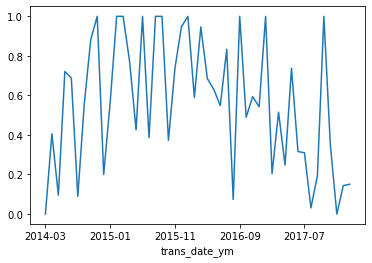

In [79]:
df_norm.loc['cyp&f schools'].plot()

<AxesSubplot:xlabel='trans_date_ym'>

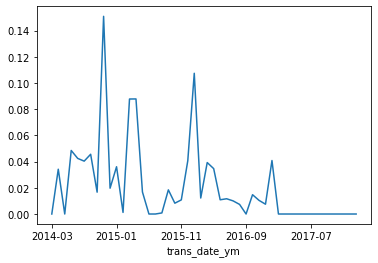

In [80]:
df_norm.loc['development'].plot()

<AxesSubplot:xlabel='trans_date_ym'>

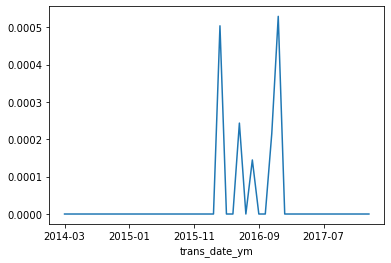

In [81]:
df_norm.loc['cyo&f'].plot()

In [40]:
df_norm.to_csv('../data/interim/serie_directorate.csv',sep='|', index=False)

# WEEK 

In [ ]:
# Only possitive gross amt
df = df[df['original_gross_amt']>0]
df['directorate'] = df['directorate'].str.lower().str.strip()
#df['directorate'].value_counts()

# Frequency of transactions made by each unique card
directorate_df = df['directorate'].value_counts()

# Transforming it into a DataFrame
directorate_df = pd.DataFrame(directorate_df)
directorate_df = directorate_df.reset_index()
directorate_df.columns = ['directorate','counts']
directorate_df

In [ ]:
df_week_pivot = pd.pivot_table(df_week,values='original_gross_amt',index='directorate',columns='trans_date',aggfunc=np.sum)#.fillna(0)

In [90]:
df_week_pivot.shape

(11, 205)